# Experimenting with image augmentation

__See the other notebook (Car_Photo_Classification_CNN.ipynb) for a description of the original process and the convolutional neural net.__

In this case the problem is not necessarily lack of photos. It's that there are multiple sizes of the exact same photo, so that if we intake all of these photos (resized to 32x32), it's likely that the testing dataset will get many of the same photos as the neural net trained on (they just originated as different sizes, but they'll have the same pixel values, so it will be easy for the neural net to classify them).

Here we apply various transformations to the images of the same car model to supplement the amount of "unique" photos in the dataset. The hope is that this will make the model more generalizable if introduced to other pictures of these cars.

In [106]:
import requests
import json
from collections import defaultdict, Counter
import numpy as np
import os
from PIL import Image, ImageOps
import urllib
import re
import string
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline

[PIL Image documentation](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html)

### Examples of Image Transformations using PIL

_Original image:_

(400, 267)


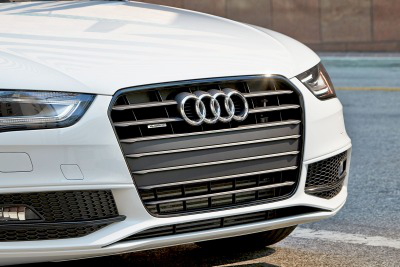

In [90]:
im = Image.open('FP_data/images/audi_a4/2016_audi_a4_sedan_20t-premium-plus-quattro_fbdg_oem_1_400.jpg', 'r')
print im.size
im

_Inverted:_

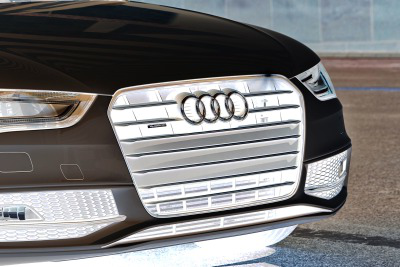

In [91]:
ImageOps.invert(im)

_Mirror image:_

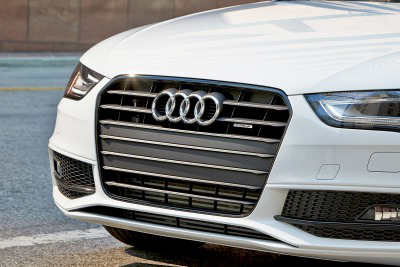

In [92]:
ImageOps.mirror(im)

_Flipped upside down:_

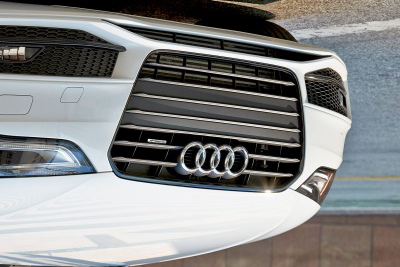

In [93]:
ImageOps.flip(im)

_Each pixel taken to the power of 1.5 :_

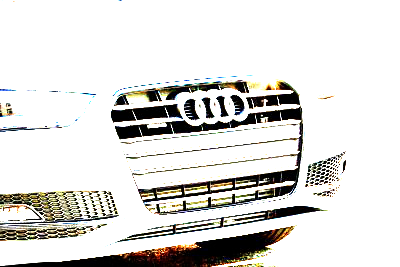

In [94]:
Image.eval(im, lambda x: x**1.5)

_Cropped and zoomed in:_

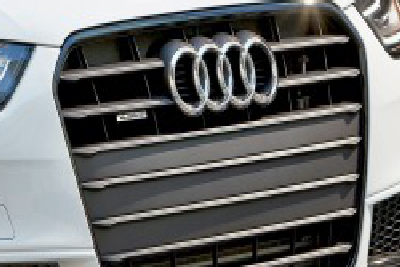

In [97]:
ImageOps.crop(im, border=75).resize((400,267))

_Rotated 60 degrees counter clockwise:_

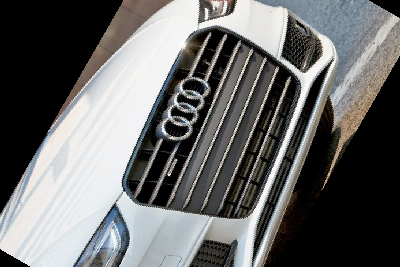

In [114]:
Image.Image.rotate(im, 60)

_Rotated 120 degrees counter clockwise:_

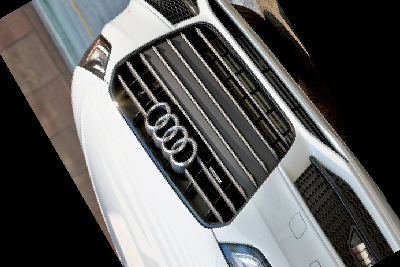

In [98]:
Image.Image.rotate(im, 120)

## Applying the image transformations to the car photos

In [73]:
def data_processing_augmentations(image_file, augment_idx):
    im = Image.open(image_file, 'r').resize((32,32))
    
    # possible augmentations
    if augment_idx == 0:
        im = ImageOps.invert(im)
    elif augment_idx == 1:
        im = ImageOps.mirror(im)
    elif augment_idx == 2:
        im = ImageOps.flip(im)
    elif augment_idx == 3:
        im = Image.eval(im, lambda x: x**2)
    elif augment_idx == 4:
        im = ImageOps.crop(im, border=12).resize((32,32))
    elif augment_idx == 5:
        im = Image.Image.rotate(im,60)
    elif augment_idx == 6:
        im = Image.Image.rotate(im,120)
    else:
        pass
    pixels = list(im.getdata())
    pixels_flat = [x for colors in pixels for x in colors]
    pixels_Im = np.reshape(pixels_flat, (1,32*32*3))
    return pixels_Im

In [63]:
labels = [fname for fname in os.listdir('FP_data') if not fname.startswith('.') and fname != 'images' and fname != 'images2']
print len(labels)

40


In [64]:
def one_hot_encode(label_idx):
    on_hot = [0] * 40
    on_hot[label_idx] = 1
    return on_hot

In [74]:
X = np.empty((1,32*32*3))
y_labels = []
for item in os.listdir('FP_data/images/'):
    if not item.startswith('.'):
        im_dir = 'FP_data/images/' + item
        print item
        for i,pic in enumerate(os.listdir(im_dir)):
            y_labels.append(item)
            pic_dir = '{0}/{1}'.format(im_dir,pic)
            pixels = data_processing_augmentations(pic_dir, i)
            X = np.append(X, pixels, axis=0)
X = X[1:,:]
assert len(X) == len(y_labels)

alfa-romeo_4c
alfa-romeo_4c_2015
audi_a4
audi_a4_2015
bmw_3-series
bmw_3-series_2015
chevrolet_colorado
chevrolet_colorado_2015
chevrolet_tahoe
chevrolet_tahoe_2015
chevrolet_volt
chevrolet_volt_2015
ford_explorer
ford_explorer_2015
ford_f-150
ford_f-150_2015
honda_civic
honda_civic_2015
honda_odyssey
honda_odyssey_2015
jeep_wrangler
jeep_wrangler_2015
mazda_3
mazda_3_2015
nissan_altima
nissan_altima_2015
nissan_frontier
nissan_frontier_2015
porsche_cayman
porsche_cayman_2015
ram_1500
ram_1500_2015
subaru_forester
subaru_forester_2015
toyota_corolla
toyota_corolla_2015
toyota_prius
toyota_prius_2015
toyota_tacoma
toyota_tacoma_2015


In [75]:
X.shape

(6822, 3072)

In [76]:
y_one_hot = []
for label in y_labels:
    idx = labels.index(label)
    one_hot = one_hot_encode(idx)
    y_one_hot.append(one_hot)
y_one_hot = np.asarray(y_one_hot)

In [77]:
print y_one_hot[:2]
print
print y_one_hot[-2:]

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1]]


In [78]:
# need to shuffle the images to ensure that the training data is representative of the whole dataset
shuffle_idx = np.random.permutation(len(X))
X_shuff, y_shuff = X[shuffle_idx], y_one_hot[shuffle_idx]

In [79]:
# training on 2474 rows, testing on 1000 rows (slightly less than 30%)
X_train, y_train, X_test, y_test = X_shuff[1000:], y_shuff[1000:], X_shuff[:1000], y_shuff[:1000]

# The Neural Net!

[Tensorflow Documentation](https://www.tensorflow.org/versions/r0.11/api_docs/python/index.html)

In [104]:
### Using a convolutional network with 3 convolution and pooling layers each and 2 fully connected layers.
### Activation functions: relu. Loss function: cross entropy. Optimizer: Adam
### Batch normalization on all layers, and dropout before the last fully connected layer.

# CODE ADAPTED FROM MIKE BOWLES, gU professor

import tensorflow as tf

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph() 
graph = tf.Graph() 
with graph.as_default():

    #inputs
    x = tf.placeholder(tf.float32, shape=[None, 32*32*3]) # [batch size, total pixels]
    y_ = tf.placeholder(tf.float32, shape=[None, 40]) # [batch size, labels]

    #reshape to image format for conv functions
    x_image = tf.reshape(x, [-1,32,32,3]) # [minibatch size, pixels height, pixels width, # channels (colors here)]
    
    #weight and bias for 1st conv
    W_conv1 = weight_variable([5, 5, 3, 32], 'W_conv1')
    b_conv1 = bias_variable([32], 'b_conv1')

    #conv and max-pool - layers 1 and 2
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) ## output = -1,32,32,32
    h_pool1 = max_pool_2x2(h_conv1) ## output = -1,16,16,32
    h_bnorm1 = tf.contrib.layers.batch_norm(h_pool1)


    #weight and bias for 2nd convolution
    W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv2')
    b_conv2 = bias_variable([64], 'b_conv2')

    #ops for layers 3 and 4
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) ## output = -1,16,16,64
    h_pool2 = max_pool_2x2(h_conv2) ## output = -1,8,8,64
    h_bnorm2 = tf.contrib.layers.batch_norm(h_pool2)
    
    #weight and bias for 3rd convolution
    W_conv3 = weight_variable([5, 5, 64, 128], 'W_conv3')
    b_conv3 = bias_variable([128], 'b_conv3')
    
    #ops for layers 5 and 6
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3) ## output = [-1,8,8,128]
    h_pool3 = max_pool_2x2(h_conv3) ## output = -1,4,4,128
    h_bnorm3 = tf.contrib.layers.batch_norm(h_pool3)

    #reshape for FC layers
    W_fc1 = weight_variable([4 * 4 * 128, 1024], 'W_fc1')
    b_fc1 = bias_variable([1024], 'b_fc1')

    #layer 7
    h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*128]) #flattening [-1,4,4,128] to [-1, 2048]
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    h_fc1_bnorm = tf.contrib.layers.batch_norm(h_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    # dropout in the later layers to reduce overfitting

    W_fc2 = weight_variable([1024, 40], 'W_fc2')
    b_fc2 = bias_variable([40], 'b_fc2')
    
    h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    h_fc2_bnorm = tf.contrib.layers.batch_norm(h_fc2)

    y_conv=tf.nn.softmax(h_fc2_bnorm)
    # probability prediction time. For each of the 40 classes, it will give a probability.

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
    # this is your loss function
    train_step = tf.train.AdamOptimizer(5e-5).minimize(cross_entropy)
    # computer understands to modify all the tf.Variables to lower this loss
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # nice printout for humans to read

    #histograms
    tVar = [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]
    tVarNames = ['W_conv1', 'b_conv1', 'W_conv2', 'b_conv2', 'W_fc1', 'b_fc1', 'W_fc2', 'b_fc2']
    #merged = tf.merge_summary([tf.histogram_summary(tv.name, tv) for (tvName, tv) in zip(tVarNames, tVar)])


#xTrain, xTest, yTrain, yTest = mnist()
with tf.Session(graph=graph) as sess:
    result = sess.run(tf.initialize_all_variables())
    writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 40
    startEnd = zip(range(0, len(X_train), miniBatchSize), range(miniBatchSize, len(X_train) + 1, miniBatchSize))
    costList = []
    nPasses = 21
    iteration = 0
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            #[cost, tbSummary] = sess.run([train_step, merged], feed_dict={x: xTrain[s:e,], y_: yTrain[s:e], keep_prob:1.0})
            cost = sess.run([train_step, cross_entropy], feed_dict={x: X_train[s:e,], y_: y_train[s:e], keep_prob:0.5})
            #writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(cost)
        testResult = sess.run([accuracy], feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})
        # need a lot of memory here
        print iPass, testResult

0 [0.28299999]
1 [0.542]
2 [0.71200001]
3 [0.81099999]
4 [0.83399999]
5 [0.84399998]
6 [0.83899999]
7 [0.84200001]
8 [0.84299999]
9 [0.83899999]
10 [0.84100002]
11 [0.83899999]
12 [0.838]
13 [0.83600003]
14 [0.83200002]
15 [0.83999997]
16 [0.833]
17 [0.83600003]
18 [0.838]
19 [0.83499998]
20 [0.83200002]


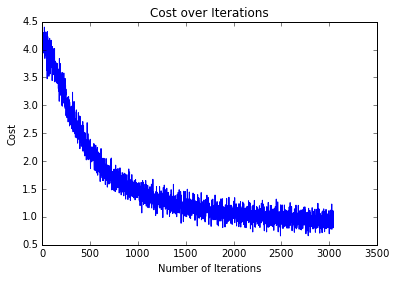

In [113]:
costs = [c for t,c in costList]
xAxis = range(len(costs))
plt.plot(xAxis, costs)
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost over Iterations')
plt.show()

This time, training and testing on transformed images, we get an accuracy of almost 84%. The model still performs fairly well. We could let the neural net continue to train until loss plateaus, and adjust the learning rate or try different activation functions and add more layers. However, before doing that, the next step I would take would be to use the transformed images for training only, and for testing use only original images. That would be more realistic to the way an image classification model such as this would be used in production.

In addition, as one of my peers mentioned when I presented this CNN, it would be interesting to see how the model performs when given slightly less perfect photos of less perfect cars. All of the images used for this project are of brand new cars, the photos taken during photo shoots, likely for ads. How would the model fare attempting to classify less-than-perfect photos of somewhat worn cars, perhaps with scratches or dents? For future work...